In [1]:
## Imports

import sys, os
from pathlib import Path

parent_folder = str(Path.cwd().parents[1])
if parent_folder not in sys.path:
    sys.path.append(parent_folder)

from sigpy import mri
import scipy
import pickle
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import seaborn as sns
import sigpy as sp
import cupy as cp
import numpy as np
from sigpy.mri.app import TotalVariationRecon, L1WaveletRecon
from scipy.io import savemat
import twixtools
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy.signal import butter,filtfilt


## My files
from resp_signal_functions import resp_signal_all_slices, resp_signal_single_slice, resp_signal_center_sample_single_slice
from resp_signal_plot_functions import *
import gating_functions
import gating_visuals
import save_data_helpers

### Load all gated data

All slices - amplitude

In [2]:
idx_amp_all, resp_trimmed_amp_all, data_bins_amp_all, spoke_bins_amp_all, index_bins_amp_all = save_data_helpers.load_gate_outputs_pickle('gates_amp_all_slices.pkl')

Loaded gates_amp_all_slices.pkl
  idx shape: (113116,)
  signal_trimmed shape: (113116,)
  data_bins: 5 elements
  spoke_bins: 5 elements
  index_bins: 5 elements


All slices - phase

In [3]:
idx_phase_all, resp_trimmed_phase_all, data_bins_phase_all, spoke_bins_phase_all, index_bins_phase_all = save_data_helpers.load_gate_outputs_pickle('gates_phase_all_slices.pkl')

Loaded gates_phase_all_slices.pkl
  idx shape: (113116,)
  signal_trimmed shape: (113116,)
  data_bins: 5 elements
  spoke_bins: 5 elements
  index_bins: 5 elements


Center slice - amplitude

In [4]:
idx_amp_cent, resp_trimmed_amp_cent, data_bins_amp_cent, spoke_bins_amp_cent, index_bins_amp_cent = save_data_helpers.load_gate_outputs_pickle('gates_amp_cent_slice.pkl')

Loaded gates_amp_cent_slice.pkl
  idx shape: (1972,)
  signal_trimmed shape: (1972,)
  data_bins: 5 elements
  spoke_bins: 5 elements
  index_bins: 5 elements


Center slice - Phase

In [5]:
idx_phase_cent, resp_trimmed_phase_cent, data_bins_phase_cent, spoke_bins_phase_cent, index_bins_phase_cent = save_data_helpers.load_gate_outputs_pickle('gates_phase_cent_slice.pkl')

Loaded gates_phase_cent_slice.pkl
  idx shape: (1972,)
  signal_trimmed shape: (1972,)
  data_bins: 5 elements
  spoke_bins: 5 elements
  index_bins: 5 elements


### 1. Visualize gating

Average signal across gates = [-1.7685029552141413e-06, -8.500967489466849e-07, -2.5236236979080244e-07, 3.4317483589603257e-07, 1.4063341866398945e-06]


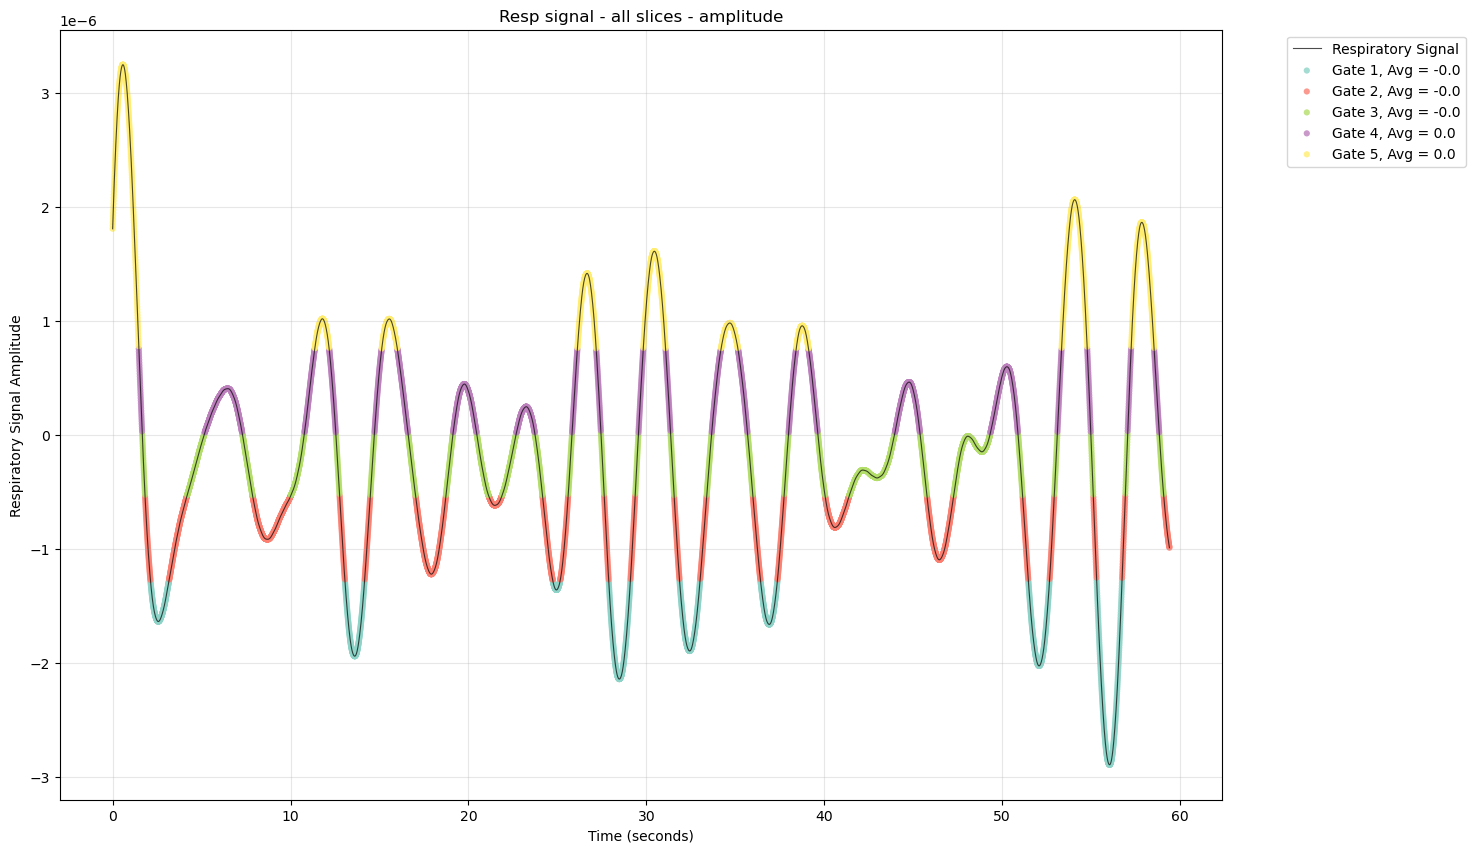

Average signal across gates = [-1.1018594994502623e-06, 3.0663352300065413e-07, 1.2146165975098566e-06, 2.3806248240709751e-07, -1.080853748578254e-06]


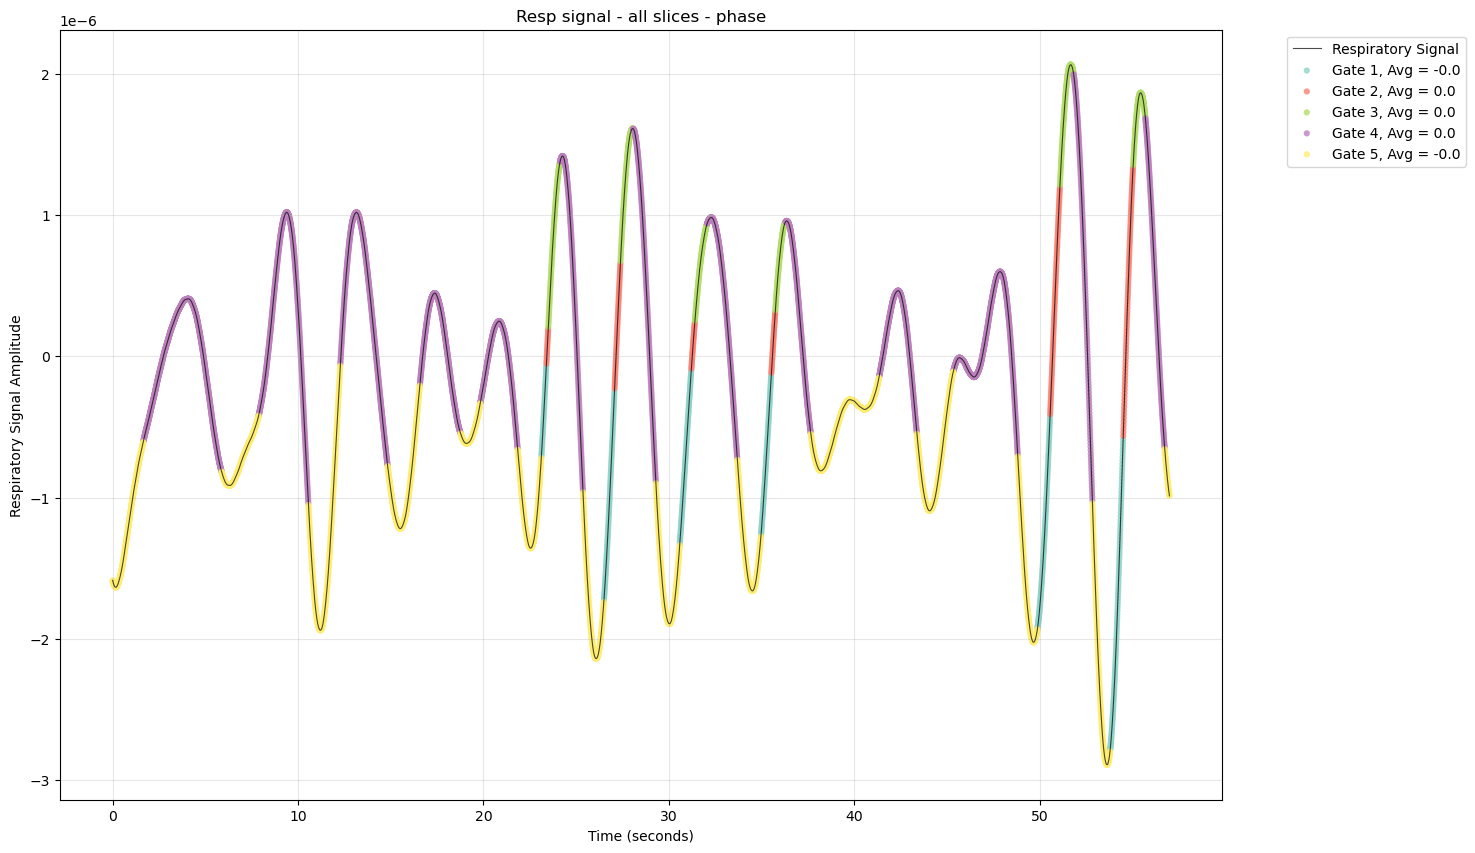

In [33]:
gating_visuals.visualize_resp_gating(resp_trimmed_amp_all[100:10000], idx_amp_all[100:10000], 
                                     TR=0.006, num_gates=5, title="Resp signal - all slices - amplitude")
gating_visuals.visualize_resp_gating(resp_trimmed_phase_all[500:10000], idx_phase_all[500:10000], 
                                     TR=0.006, num_gates=5, title="Resp signal - all slices - phase")

Average signal across gates = [-2.9949424332709406e-05, -1.1234648545283162e-05, -4.806176709002375e-07, 1.2376850822561544e-05, 2.928256078154013e-05]


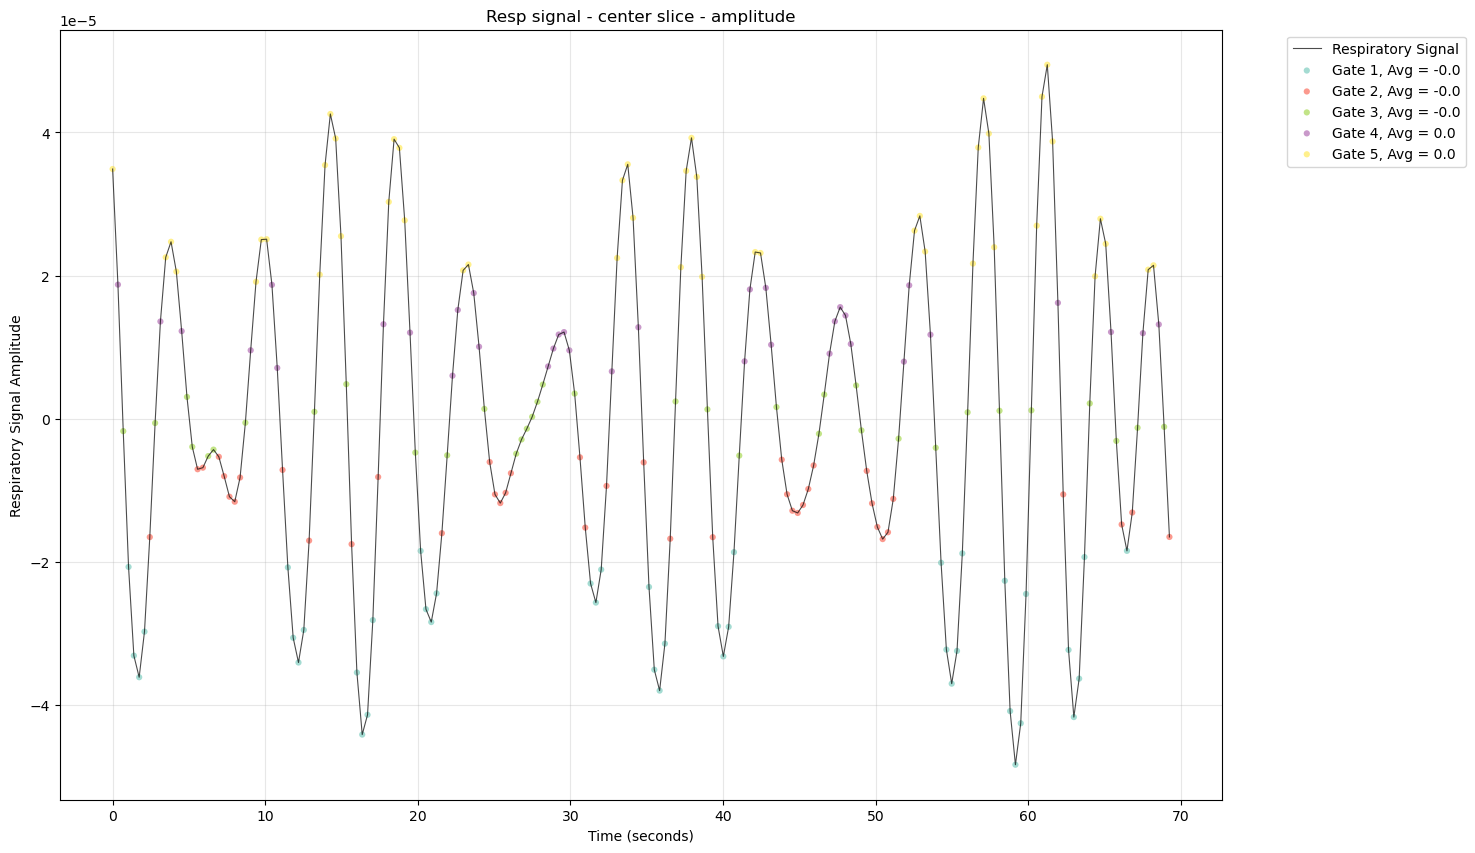

Average signal across gates = [-2.1250431138238688e-05, 7.858496149162658e-06, 2.7914379505444354e-05, 6.283036412197402e-06, -1.9854683765582854e-05]


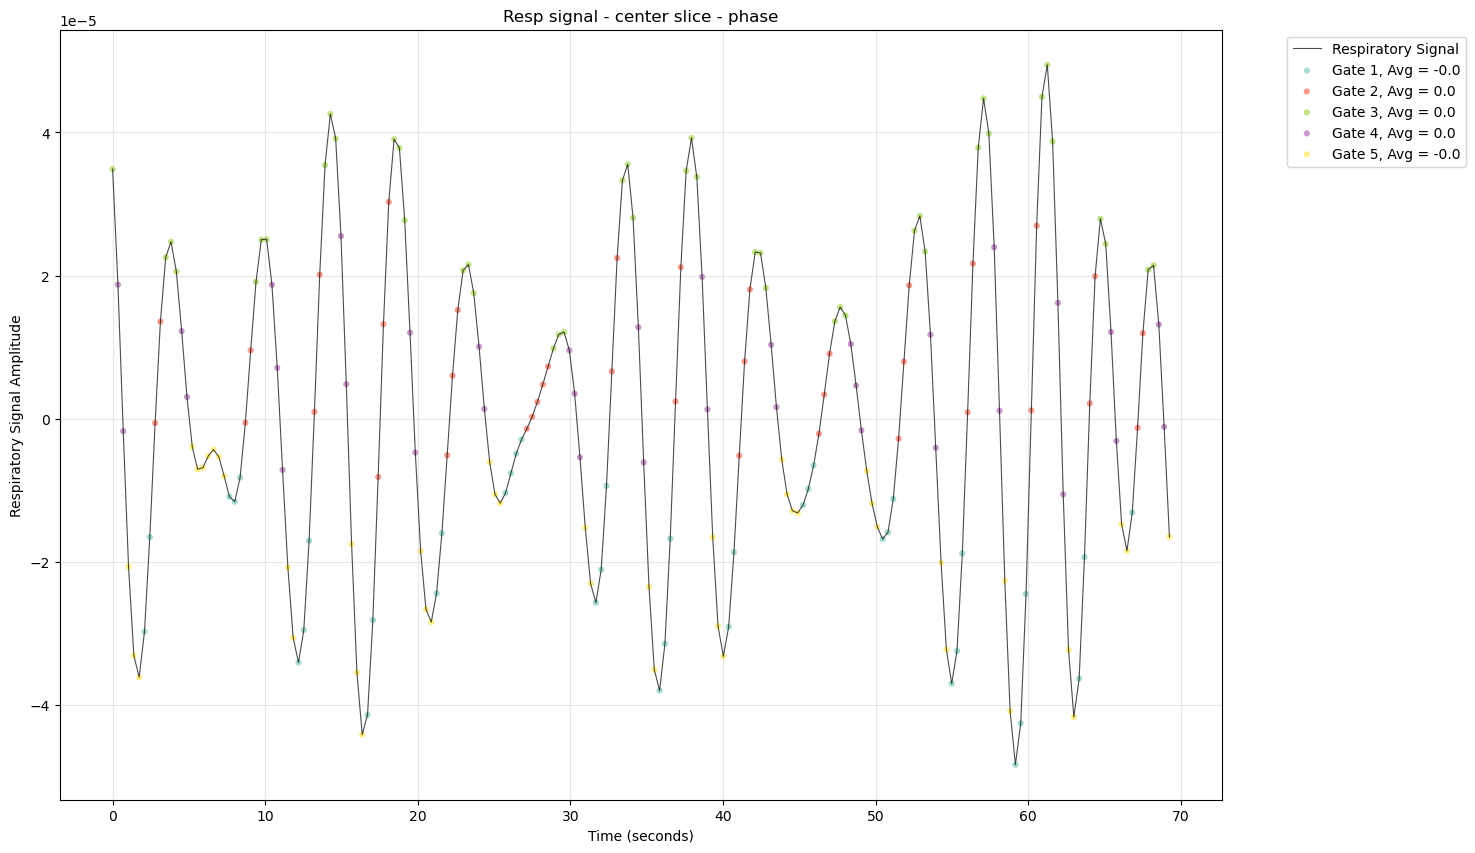

In [7]:
gating_visuals.visualize_resp_gating(resp_trimmed_amp_cent[100:300], idx_amp_cent[100:300], 
                                     TR=0.348, num_gates=5, title="Resp signal - center slice - amplitude")
gating_visuals.visualize_resp_gating(resp_trimmed_phase_cent[100:300], idx_phase_cent[100:300], 
                                     TR=0.348, num_gates=5, title="Resp signal - center slice - phase")

### 2. View angular coverage

All slices

In [8]:
def reshape_gate_all_slices(data_bins, spoke_bins, num_gates, num_coils, num_slices, num_samples, ndims):
    data_bins_reshaped =[]
    spoke_bins_reshaped = []
    for i in range(num_gates):
        data_bin = data_bins[i]
        spoke_bin = spoke_bins[i]
        
        N = data_bin.shape[1]  # total spokes in this gate
    
        # Complete slice groups
        max_valid = (N // num_slices) * num_slices
        
        if max_valid < N:
            print(f"Warning: Truncating {N - max_valid} incomplete spokes to maintain slice structure")
        
        # Truncate to complete slice groups
        data_bin = data_bin[:, :max_valid, :]
        spoke_bin = spoke_bin[:max_valid, :, :]
        
        # Calculate spokes per slice for this gate
        num_spokes_per_slice = max_valid // num_slices
        
        # Reshape back to 4D
        data_bin = data_bin.reshape(num_coils, num_spokes_per_slice, num_slices, num_samples)
        spoke_bin = spoke_bin.reshape(num_spokes_per_slice, num_slices, num_samples, ndims)
        print(f'data_bin[{i}] final shape  {data_bin.shape}')
        print(f'spoke_bin[{i}] final shape  {spoke_bin.shape}')
        ## add to array
        data_bins_reshaped.append(data_bin)
        spoke_bins_reshaped.append(spoke_bin)

    return data_bins_reshaped, spoke_bins_reshaped

In [9]:
data_bins_amp_all_rshp, spoke_bins_amp_all_rshp = reshape_gate_all_slices(data_bins_amp_all,
                                                                         spoke_bins_amp_all, 
                                                                         num_gates=5,
                                                                         num_coils=15,
                                                                         num_slices=58, 
                                                                         num_samples = 256,
                                                                         ndims =3)

data_bin[0] final shape  (15, 390, 58, 256)
spoke_bin[0] final shape  (390, 58, 256, 3)
data_bin[1] final shape  (15, 390, 58, 256)
spoke_bin[1] final shape  (390, 58, 256, 3)
data_bin[2] final shape  (15, 390, 58, 256)
spoke_bin[2] final shape  (390, 58, 256, 3)
data_bin[3] final shape  (15, 390, 58, 256)
spoke_bin[3] final shape  (390, 58, 256, 3)
data_bin[4] final shape  (15, 390, 58, 256)
spoke_bin[4] final shape  (390, 58, 256, 3)


In [10]:
data_bins_phase_all_rshp, spoke_bins_phase_all_rshp = reshape_gate_all_slices(data_bins_phase_all,
                                                                         spoke_bins_phase_all, 
                                                                         num_gates=5,
                                                                         num_coils=15,
                                                                         num_slices=58, 
                                                                         num_samples = 256,
                                                                         ndims =3)

data_bin[0] final shape  (15, 447, 58, 256)
spoke_bin[0] final shape  (447, 58, 256, 3)
data_bin[1] final shape  (15, 409, 58, 256)
spoke_bin[1] final shape  (409, 58, 256, 3)
data_bin[2] final shape  (15, 253, 58, 256)
spoke_bin[2] final shape  (253, 58, 256, 3)
data_bin[3] final shape  (15, 391, 58, 256)
spoke_bin[3] final shape  (391, 58, 256, 3)
data_bin[4] final shape  (15, 448, 58, 256)
spoke_bin[4] final shape  (448, 58, 256, 3)


In [11]:
ksp_data_shape = (15, 58, 2002, 256)

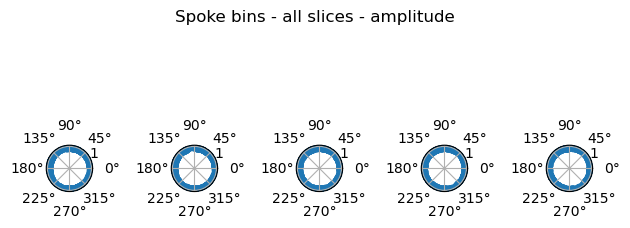

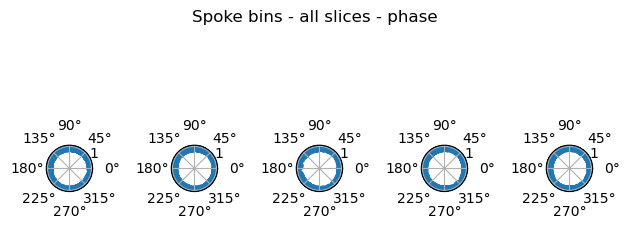

In [12]:
gating_visuals.view_angular_converage(ksp_data_shape, num_gates=5, 
                                      spoke_bins=spoke_bins_amp_all_rshp,
                                      title="Spoke bins - all slices - amplitude")
gating_visuals.view_angular_converage(ksp_data_shape, num_gates=5, 
                                      spoke_bins=spoke_bins_phase_all_rshp,
                                      title="Spoke bins - all slices - phase")

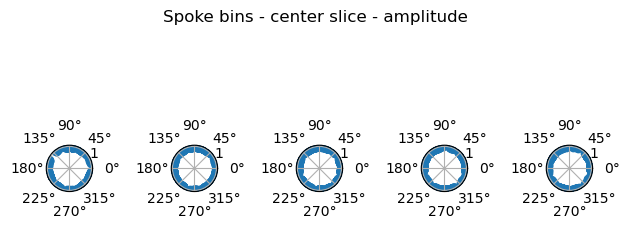

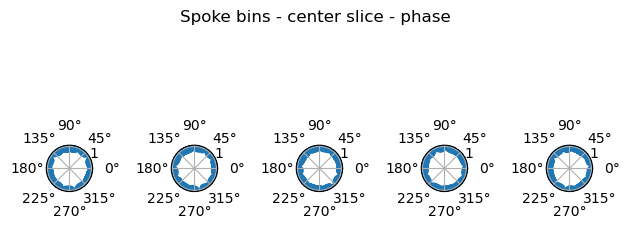

In [13]:
gating_visuals.view_angular_converage(ksp_data_shape, num_gates=5, 
                                      spoke_bins=spoke_bins_amp_cent,
                                      title="Spoke bins - center slice - amplitude")
gating_visuals.view_angular_converage(ksp_data_shape, num_gates=5, 
                                      spoke_bins=spoke_bins_phase_cent,
                                      title="Spoke bins - center slice - phase")

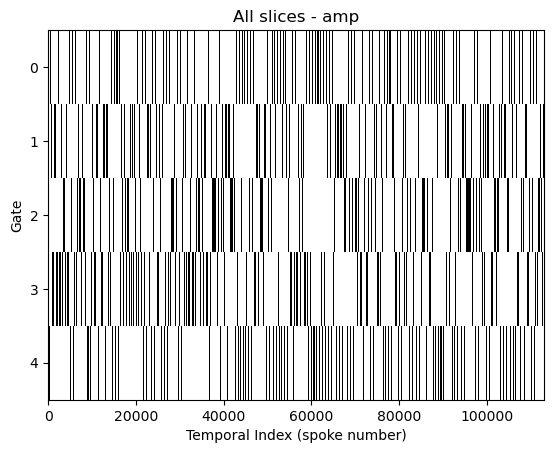

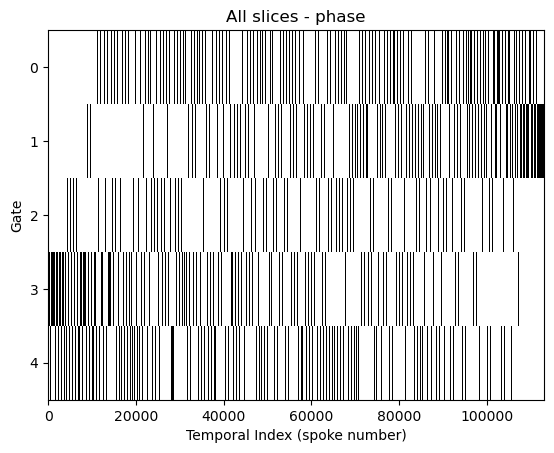

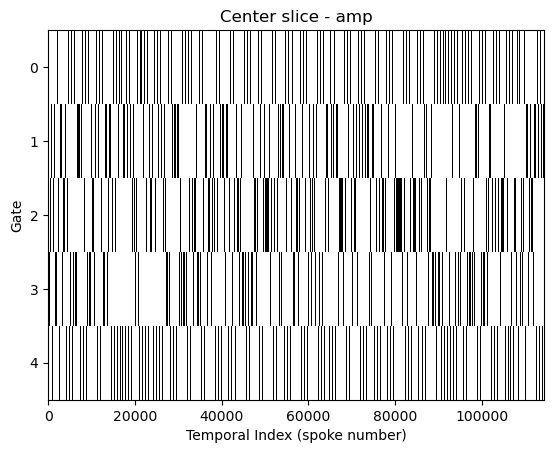

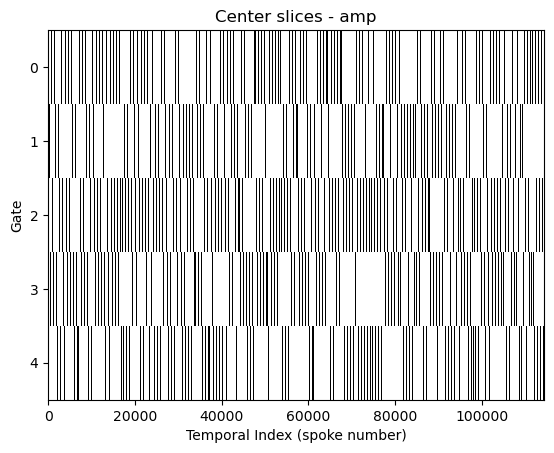

In [14]:
gating_visuals.view_temporal_clustering(index_bins_amp_all, num_gates=5, title="All slices - amp")
gating_visuals.view_temporal_clustering(index_bins_phase_all, num_gates=5, title="All slices - phase")
gating_visuals.view_temporal_clustering(index_bins_amp_cent, num_gates=5, title="Center slice - amp")
gating_visuals.view_temporal_clustering(index_bins_phase_cent, num_gates=5, title="Center slices - amp")

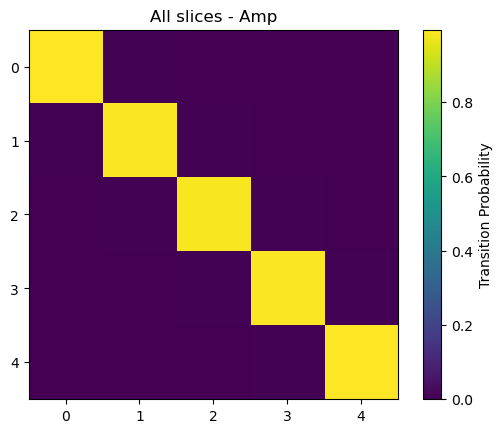

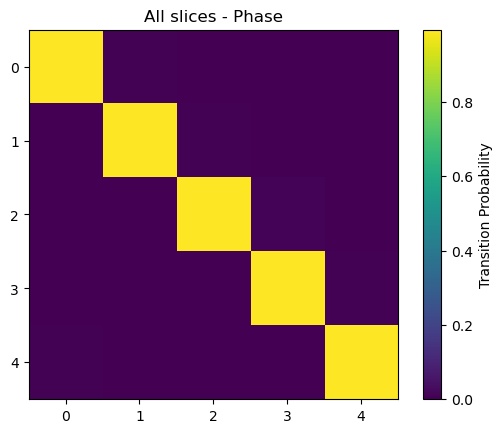

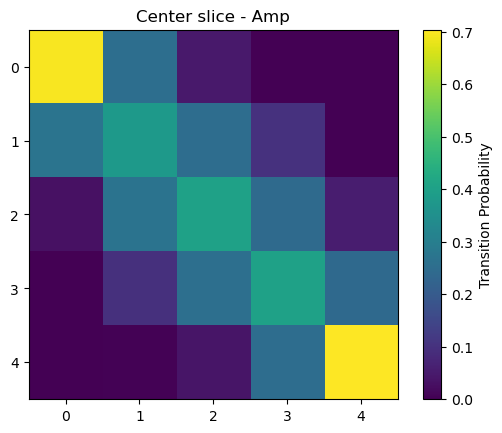

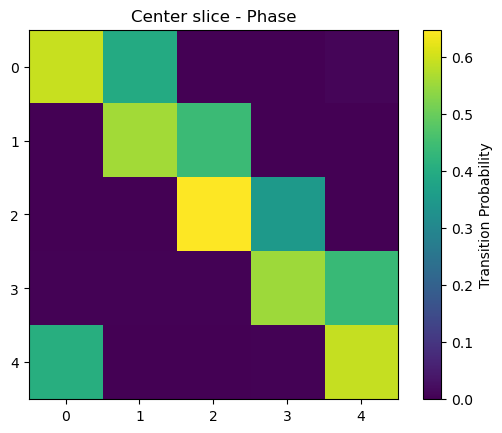

In [17]:
trans_matrix_amp_all = gating_visuals.gate_transition_matrix(idx_amp_all, 
                                                             num_gates=5, title="All slices - Amp")
trans_matrix_phase_all = gating_visuals.gate_transition_matrix(idx_phase_all, 
                                                             num_gates=5, title="All slices - Phase")
trans_matrix_amp_cent = gating_visuals.gate_transition_matrix(idx_amp_cent, 
                                                             num_gates=5, title="Center slice - Amp")
trans_matrix_phase_cent = gating_visuals.gate_transition_matrix(idx_phase_cent, 
                                                             num_gates=5, title="Center slice - Phase")

In [22]:
print(f'\nAmp all:')
print(f'{trans_matrix_amp_all}')
print(f'\nPhase all:')
print(f'{trans_matrix_phase_all}')


Amp all:
[[0.99473987 0.00526013 0.         0.         0.        ]
 [0.00521593 0.9874464  0.00733767 0.         0.        ]
 [0.         0.00729378 0.98541243 0.00729378 0.        ]
 [0.         0.         0.00729346 0.98726959 0.00543694]
 [0.         0.         0.         0.0054367  0.9945633 ]]

Phase all:
[[9.93834534e-01 5.93426072e-03 0.00000000e+00 3.85341605e-05
  1.92670803e-04]
 [5.48014501e-04 9.93508136e-01 5.94384959e-03 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 6.80272109e-05 9.90408163e-01 9.52380952e-03
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.93350654e-01
  6.64934607e-03]
 [5.60826643e-03 0.00000000e+00 0.00000000e+00 3.84127838e-04
  9.94007606e-01]]


In [23]:
print(f'\nAmp center: ')
print(f'{trans_matrix_amp_cent}')
print(f'\nPhase center:')
print(f'{trans_matrix_phase_cent}')


Amp center: 
[[0.69620253 0.25316456 0.04810127 0.00253165 0.        ]
 [0.2715736  0.37817259 0.25126904 0.09898477 0.        ]
 [0.03053435 0.26717557 0.40203562 0.24427481 0.05597964]
 [0.00253807 0.0964467  0.25634518 0.4035533  0.24111675]
 [0.         0.00506329 0.04050633 0.25063291 0.70379747]]

Phase center:
[[0.59445844 0.39546599 0.         0.         0.01007557]
 [0.         0.55922865 0.44077135 0.         0.        ]
 [0.         0.00218341 0.64847162 0.34934498 0.        ]
 [0.00278552 0.00278552 0.00278552 0.55431755 0.43732591]
 [0.40609137 0.         0.         0.00253807 0.59137056]]


In [26]:
def check_duplicates(index_bins):
    # Flatten all indices
    all_indices = np.concatenate(index_bins)

    # Check for duplicates
    unique_indices = np.unique(all_indices)

    print(f"Total indices assigned: {len(all_indices)}")
    print(f"Unique indices: {len(unique_indices)}")
    print(f"Duplicates: {len(all_indices) - len(unique_indices)}")

    # Find which indices are duplicated
    if len(all_indices) != len(unique_indices):
        counts = np.bincount(all_indices)
        duplicated = np.where(counts > 1)[0]
        print(f"Duplicated indices: {duplicated}")
        print(f"Their counts: {counts[duplicated]}")

In [28]:
check_duplicates(index_bins_amp_all)

Total indices assigned: 113116
Unique indices: 113116
Duplicates: 0


In [31]:
# Check all pairs of gates
def check_overlap(num_gates, index_bins):
    for i in range(num_gates):
        for j in range(i+1, num_gates):
            overlap = np.intersect1d(index_bins[i], index_bins[j])
            if len(overlap) > 0:
                print(f"Gates {i+1} and {j+1} share {len(overlap)} spokes: {overlap[:10]}...")

In [32]:
check_overlap(num_gates=5, index_bins=index_bins_amp_all)